In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import seaborn as sns
import matplotlib.pyplot as plt

#If cuda device exists, use that. If not, default to CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [20]:
#Hyperparameters
num_epochs = 50
# num_classes = 10
batch_size = 128
learning_rate = 0.001
z_dim = 64

In [3]:
#Load MNIST data set
train_dataset = torchvision.datasets.MNIST(root='/data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          download=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 154114827.93it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39240587.57it/s]


Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37055108.80it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 8425709.32it/s]


Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 146670680.99it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 100778447.44it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43054524.95it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20911667.14it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Get all targets
targets = train_dataset.targets
# Create target_indices
target_indices = np.arange(len(targets))
# Split into train and validation
train_idx, val_idx = train_test_split(target_indices, train_size=0.8)

# Specify which class to remove from train
classidx_to_remove = 0
# Get indices to keep from train split
idx_to_keep = targets[train_idx]!=classidx_to_remove
# Only keep your desired classes
train_idx = train_idx[idx_to_keep]

train_dataset = Subset(train_dataset, train_idx)
val_dataset = Subset(train_dataset, val_idx)

In [7]:
#Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1, 
                                          shuffle=False)

In [8]:
class Autoencoder(nn.Module):
    def __init__(self,z_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, z_dim))

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x) # f_\theta
        xhat = self.decoder(z) # g_\phi
        return xhat


In [9]:
len(train_dataset), len(val_dataset), len(test_dataset)

(43253, 12000, 10000)

In [10]:
# device

In [21]:
model = Autoencoder(z_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)
print(f"Model is on device: {next(model.parameters()).device}")

# model = model.to(device)

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader):
        x = x.view(x.shape[0], -1)
        input = x.to(device)
        # print(input.shape)
        # Forward pass
        outputs = model(input)
        loss = criterion(outputs, input)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 300 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Model is on device: cuda:0
Epoch [1/50], Step [300/338], Loss: 0.0262
Epoch [2/50], Step [300/338], Loss: 0.0209
Epoch [3/50], Step [300/338], Loss: 0.0173
Epoch [4/50], Step [300/338], Loss: 0.0155
Epoch [5/50], Step [300/338], Loss: 0.0139
Epoch [6/50], Step [300/338], Loss: 0.0149
Epoch [7/50], Step [300/338], Loss: 0.0137
Epoch [8/50], Step [300/338], Loss: 0.0125
Epoch [9/50], Step [300/338], Loss: 0.0125
Epoch [10/50], Step [300/338], Loss: 0.0128
Epoch [11/50], Step [300/338], Loss: 0.0126
Epoch [12/50], Step [300/338], Loss: 0.0120
Epoch [13/50], Step [300/338], Loss: 0.0113
Epoch [14/50], Step [300/338], Loss: 0.0110
Epoch [15/50], Step [300/338], Loss: 0.0097
Epoch [16/50], Step [300/338], Loss: 0.0115
Epoch [17/50], Step [300/338], Loss: 0.0103
Epoch [18/50], Step [300/338], Loss: 0.0103
Epoch [19/50], Step [300/338], Loss: 0.0092
Epoch [20/50], Step [300/338], Loss: 0.0101
Epoch [21/50], Step [300/338], Loss: 0.0103
Epoch [22/50], Step [300/338], Loss: 0.0098
Epoch [23/50],

In [22]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [23]:
# Get all targets
targets = test_dataset.targets
# Create target_indices
target_indices = np.arange(len(targets))

# Specify which class to remove from train
classidx_removed = 0
# Get indices to keep from train split
idx_to_kept = targets!=classidx_to_remove
idx_to_remove = targets==classidx_to_remove

In [24]:
# Only keep your desired classes
test_dataset_inliers = Subset(test_dataset, idx_to_kept)
test_dataset_outliers = Subset(test_dataset, idx_to_remove)

In [25]:
test_inlier_loader = torch.utils.data.DataLoader(dataset=test_dataset_inliers,
                                          batch_size=batch_size, 
                                          shuffle=False)

test_outlier_loader = torch.utils.data.DataLoader(dataset=test_dataset_outliers,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [26]:
total_step = len(train_loader)
model.eval()
score_list = []
for i, (x, y) in enumerate(test_loader):
    x = x.view(x.shape[0], -1)
    input = x.to(device)
    # print(input.shape)
    # Forward pass
    outputs = model(input)
    loss = criterion(outputs, input)
    # print(y, loss.cpu().detach().numpy())
    score_list.append((y.item(), loss.cpu().detach().numpy().item()))
    # if (i+1) % 100 == 0:
    #     print ('Batch [{}/{}], Loss: {:.4f}' 
    #             .format(i+1, total_step, loss.item()))

In [27]:
score_list

[(7, 0.004149726592004299),
 (2, 0.012919449247419834),
 (1, 0.0024628236424177885),
 (0, 0.010742739774286747),
 (4, 0.007731402292847633),
 (1, 0.001352265477180481),
 (4, 0.011241390369832516),
 (9, 0.012938553467392921),
 (5, 0.010708942078053951),
 (9, 0.006931759882718325),
 (0, 0.012070016004145145),
 (6, 0.01481438148766756),
 (9, 0.004302201326936483),
 (0, 0.011163103394210339),
 (1, 0.0034848633222281933),
 (5, 0.015166224911808968),
 (9, 0.00654755812138319),
 (7, 0.006385574582964182),
 (3, 0.020886870101094246),
 (4, 0.005501462146639824),
 (9, 0.0076116034761071205),
 (6, 0.00525303278118372),
 (6, 0.013896661810576916),
 (5, 0.00744476355612278),
 (4, 0.00820695236325264),
 (0, 0.020643403753638268),
 (7, 0.008758323267102242),
 (4, 0.005977382883429527),
 (0, 0.011543168686330318),
 (1, 0.003867588471621275),
 (3, 0.005608535837382078),
 (1, 0.0035202435683459044),
 (3, 0.006012489087879658),
 (4, 0.016257405281066895),
 (7, 0.006183730438351631),
 (2, 0.01379849109798

In [28]:
recon_error = { k: [0, 0,] for k in range(10)}

for digit, error in score_list:
  recon_error[digit][0] += error
  recon_error[digit][1] += 1


In [29]:
recon_error

{0: [14.35775045491755, 980],
 1: [3.466218087472953, 1135],
 2: [11.656193751376122, 1032],
 3: [9.087339542573318, 1010],
 4: [8.302766672568396, 982],
 5: [8.738978260196745, 892],
 6: [9.329061210388318, 958],
 7: [7.056823444319889, 1028],
 8: [10.283964320784435, 974],
 9: [6.888659464428201, 1009]}

In [30]:
for key in recon_error.keys():
  v = recon_error[key]
  print(key, v[0]/v[1])

0 0.01465076577032403
1 0.003053936640945333
2 0.011294761386992367
3 0.008997365883735958
4 0.008454955878379222
5 0.009797060829816979
6 0.009738059718568181
7 0.006864614245447363
8 0.010558484928936792
9 0.0068272145336255715


In [31]:
per_class_recon_error = { k: [] for k in range(10)}

for digit, error in score_list:
  per_class_recon_error[digit].append(error)


<Axes: ylabel='Count'>

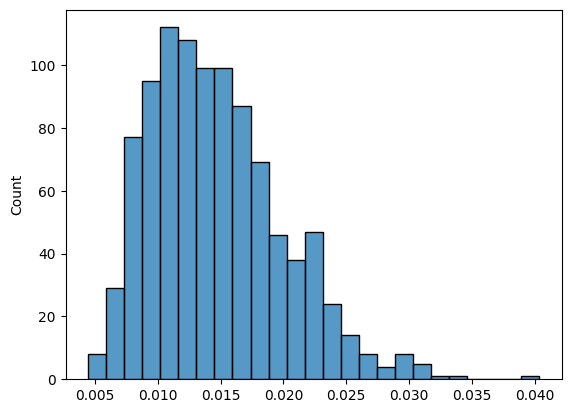

In [32]:
sns.histplot(per_class_recon_error[0])

<Axes: ylabel='Count'>

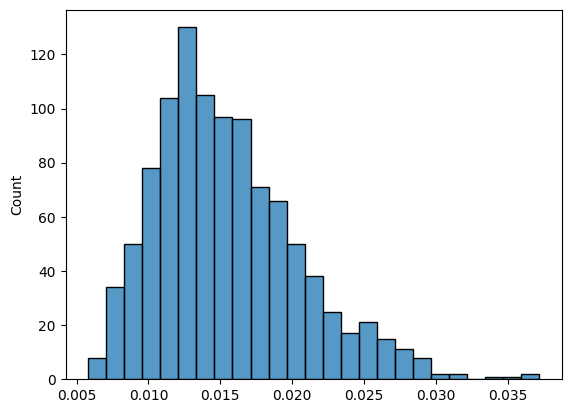

In [19]:
sns.histplot(per_class_recon_error[2])

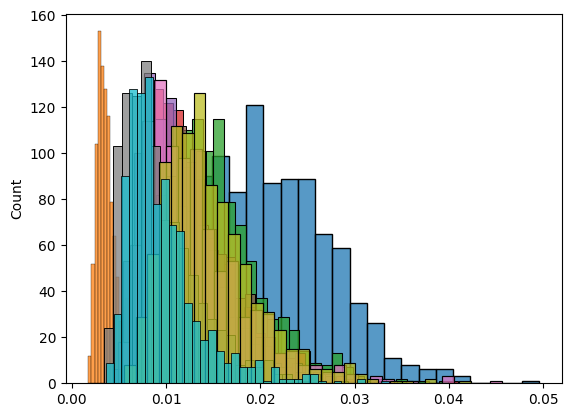

In [ ]:
# fig, axs = plt.subplots(2, 5)

for key in per_class_recon_error.keys():
  # axs[key//5, key % 2] = 
  sns.histplot(per_class_recon_error[key])
  ax.set_xlabel("reconstruction error")
  ax.set_title(f"Reconstruction error histogram for class {key}")
  ax.plot()